In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import requests
import json
import re

In [85]:
import matplotlib.pyplot as plt

In [2]:
#Adding user agent can prevent us from being blocked by Amazon while scraping the data 
#Reference: https://www.geeksforgeeks.org/scraping-amazon-product-information-using-beautiful-soup/
HEADERS = ({'User-Agent':
            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
             'Accept-Language': 'en-US, en;q=0.5'})
# timescale 
year = list(range(2011,2022))

In [17]:
r = requests.get('https://www.barnesandnoble.com/b/books/awards/best-books-of-the-year/_/N-29Z8q8Z1qrh', headers=HEADERS)
soup = BeautifulSoup(r.content, "html")
content = soup.find_all('a', class_ ="bread-crumbs__item")

In [18]:
content

[<a class="bread-crumbs__item" href="/b/books/best-books-of-the-year/best-books-of-the-year-2002/_/N-29Z8q8Z1qri;jsessionid=524ACA898E848192811549138E1FA384.prodny_store01-atgap13" rel="">Best Books of the Year 2002</a>,
 <a class="bread-crumbs__item" href="/b/books/best-books-of-the-year/best-books-of-the-year-2003/_/N-29Z8q8Z1qu7;jsessionid=524ACA898E848192811549138E1FA384.prodny_store01-atgap13" rel="">Best Books of the Year 2003</a>,
 <a class="bread-crumbs__item" href="/b/books/best-books-of-the-year/best-books-of-the-year-2004/_/N-29Z8q8Z1qvd;jsessionid=524ACA898E848192811549138E1FA384.prodny_store01-atgap13" rel="">Best Books of the Year 2004</a>,
 <a class="bread-crumbs__item" href="/b/books/best-books-of-the-year/best-books-of-the-year-2005/_/N-29Z8q8Z1qwm;jsessionid=524ACA898E848192811549138E1FA384.prodny_store01-atgap13" rel="">Best Books of the Year 2005</a>,
 <a class="bread-crumbs__item" href="/b/books/best-books-of-the-year/best-books-of-the-year-2006/_/N-29Z8q8Z1qy6;jse

In [19]:
ALLURL = []
for i in content[9:20]:
    URL = []
    
    for j in range(1,11):
        B_N_book_url ='https://www.barnesandnoble.com/'+ i['href'] +'?Nrpp=20&page={}'.format(j)

        r = requests.get(B_N_book_url, headers=HEADERS)
        soup = BeautifulSoup(r.content, "html")
        content = soup.find_all('div', 
                                class_ ="product-shelf-info product-info-view text--left pl-qa-s")
        
        for _ in range(len(content)):
            link_str = content[_].find(class_ = 'link')['href']
            url = 'https://www.barnesandnoble.com/' + link_str
            URL.append(url)
    
    ALLURL.append(URL)

In [27]:
len(ALLURL) #11 years

11

In [26]:
len(ALLURL[0]) #each year has 200 books 

200

In [340]:
year = 2011
print(year)
for suburl in ALLURL:
    OV = [] #overview
    ER = [] #editorial reviews 
    Texts = []
    for url in suburl:
        r = requests.get(url, headers=HEADERS)
        soup = BeautifulSoup(r.content, "html")
        OVContent = soup.find_all('div',  class_ ='overview-cntnt')
        #print(url)
        
      
        ov = OVContent[0].text.strip()
        er = ''
        
        ERContent = soup.find_all('div',  class_ ="container row editorial-reviews mt-m")
        if len(ERContent) != 0: 
            ER = ERContent[0].find_all('p')
        
            for i in ER:
                er += i.text
               
        else:
            er ='N/A'

          
        text = ov + er
        Texts.append(text)
        
    book_content = pd.DataFrame({
     'Text': Texts
    })
    
    book_content.to_csv('book_texts{}.csv'.format(year), encoding='utf-8', index=False)
    year += 1 

In [123]:
df1 = pd.read_csv('book_texts2011.csv')
df1['Year'] = 2011

In [133]:
df2 = pd.read_csv('book_texts2021.csv')
df2['Year'] = 2021
df3 = pd.concat([df3, df2], axis=0)

In [135]:
#df3.to_csv('B&N_ALL_TEXTS.csv', encoding='utf-8')

In [269]:
df3 =pd.read_csv('B&N_ALL_TEXTS.csv')

In [193]:
df3

,Unnamed: 0,Text,Year
0,0,From Caldecott Honor artist Melissa Sweet come...,2011
1,1,From a New York Times bestselling and Hugo awa...,2011
2,2,"A masterpiece of postwar Polish literature, St...",2011
3,3,From the #1 New York Times-bestselling author ...,2011
4,4,Book one of the New York Times-bestselling All...,2011
...,...,...,...
2195,195,"“A haunted work, full of voices old and new. I...",2021
2196,196,ONE OF THE BEST BOOKS OF THE YEAR! - Publisher...,2021
2197,197,“Much more than a page-turner. It’s the first ...,2021
2198,198,Three kids who don’t belong. A room that shoul...,2021


### Data Pre-processing

In [58]:
import nltk
from nltk.corpus import wordnet as wn
from nltk import pos_tag

In [60]:
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim import corpora, models
from gensim.utils import effective_n_jobs

In [198]:
def process(df):
    
    stopwords = nltk.corpus.stopwords.words('english')
    defined = ['book', 'books','read', 'story','stories','character','characters', 'help', 'author', 'authors',
               'write','much','many','little','less','im','time','times','new','york','one','best','bestselling', 
              'year', 'like','first','people','even','also','america','american','novel','readers','us','review','one',
              'two','three','four','five','years','makes','make','written','writing','way','reviews','never']
    stopwords = stopwords + defined
    

    clean = df.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())
    
    tokenize = lambda text: [i for i in nltk.word_tokenize(text) if i not in stopwords]
    tokens = clean.apply(tokenize)
    return tokens

In [289]:
df3['Tokens'] = process(df3['Text'])

In [290]:
df3.head()

,Unnamed: 0,Text,Year,Tokens
0,0,From Caldecott Honor artist Melissa Sweet come...,2011,"[caldecott, honor, artist, melissa, sweet, com..."
1,1,From a New York Times bestselling and Hugo awa...,2011,"[hugo, awardwinning, comes, modern, masterwork..."
2,2,"A masterpiece of postwar Polish literature, St...",2011,"[masterpiece, postwar, polish, literature, sto..."
3,3,From the #1 New York Times-bestselling author ...,2011,"[1, timesbestselling, lincoln, highway, gentle..."
4,4,Book one of the New York Times-bestselling All...,2011,"[timesbestselling, souls, trilogya, wonderfull..."


In [291]:
df3['Format'] = df3['Tokens'].apply(lambda x: pos_tag(x))

In [292]:
df3['Format'].head()

0    [(caldecott, NN), (honor, NN), (artist, NN), (...
1    [(hugo, NN), (awardwinning, VBG), (comes, VBZ)...
2    [(masterpiece, JJ), (postwar, JJ), (polish, JJ...
3    [(1, CD), (timesbestselling, VBG), (lincoln, J...
4    [(timesbestselling, VBG), (souls, NNS), (trilo...
Name: Format, dtype: object

In [293]:
df3['NewTokens'] = df3['Format'].apply(lambda x: [i[0] for i in x if i[1] in ('JJ','NN')])

In [294]:
df3['NewTokens'].head()

0    [caldecott, honor, artist, sweet, perfect, day...
1    [hugo, modern, masterwork, science, fiction, c...
2    [masterpiece, postwar, polish, literature, sto...
3    [lincoln, highway, gentleman, stylish, boston,...
4    [imaginative, grownup, fantasy, magic, potter,...
Name: NewTokens, dtype: object

In [295]:
df3.head()

,Unnamed: 0,Text,Year,Tokens,Format,NewTokens
0,0,From Caldecott Honor artist Melissa Sweet come...,2011,"[caldecott, honor, artist, melissa, sweet, com...","[(caldecott, NN), (honor, NN), (artist, NN), (...","[caldecott, honor, artist, sweet, perfect, day..."
1,1,From a New York Times bestselling and Hugo awa...,2011,"[hugo, awardwinning, comes, modern, masterwork...","[(hugo, NN), (awardwinning, VBG), (comes, VBZ)...","[hugo, modern, masterwork, science, fiction, c..."
2,2,"A masterpiece of postwar Polish literature, St...",2011,"[masterpiece, postwar, polish, literature, sto...","[(masterpiece, JJ), (postwar, JJ), (polish, JJ...","[masterpiece, postwar, polish, literature, sto..."
3,3,From the #1 New York Times-bestselling author ...,2011,"[1, timesbestselling, lincoln, highway, gentle...","[(1, CD), (timesbestselling, VBG), (lincoln, J...","[lincoln, highway, gentleman, stylish, boston,..."
4,4,Book one of the New York Times-bestselling All...,2011,"[timesbestselling, souls, trilogya, wonderfull...","[(timesbestselling, VBG), (souls, NNS), (trilo...","[imaginative, grownup, fantasy, magic, potter,..."


In [212]:
def prepare_data(tokens):
    '''
    Prepares Pandas series of lists of tokens for use within a Gensim topic model
    
    Returns an id2word dictionary + bag of words corpus
    '''
    # Initialize Series of tokens as Gensim Dictionary for further processing
    dictionary = corpora.Dictionary([i for i in tokens])

    # Convert dictionary into bag of words format: list of (token_id, token_count) tuples
    bow_corpus = [dictionary.doc2bow(text) for text in tokens]
    
    return dictionary, bow_corpus

In [296]:
# Prepare Data for Topic Modeling with Gensim
dictionary, bow_corpus = prepare_data(df3['NewTokens'])

## Topic Modeling

#### Reference: Some of the code are directly from class lecture

In [215]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    '''
    Computes Coherence values for LDA models with differing numbers of topics.
    
    Returns list of models along with their respective coherence values (pick
    models with the highest coherence)
    '''
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamulticore.LdaMulticore(corpus=corpus,
                                                 id2word=dictionary,
                                                 num_topics=num_topics,
                                                 workers=effective_n_jobs(-1),
                                                 passes=20,
                                                 iterations=400)
        model_list.append(model)
        coherence_model = models.coherencemodel.CoherenceModel(model=model, 
                                                               corpus=corpus,
                                                               dictionary=dictionary,
                                                               coherence='u_mass')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

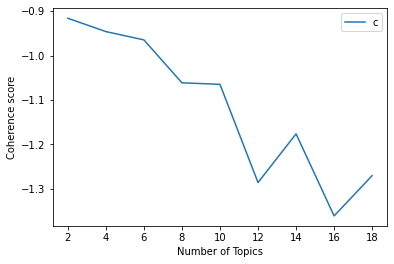

In [297]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                           corpus=bow_corpus,
                                                           texts=df3['NewTokens'],
                                                           start=2,
                                                           limit=20,
                                                           step=2)
plt.plot(range(2, 20, 2), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best');

In [298]:
ldamodel = model_list[0]
ldamodel.save('lda.model')

In [299]:
for i, topic in ldamodel.show_topics(formatted=False, num_words=20):
    print('Topic {}: \n{}'.format(i, [w[0] for w in topic]))

Topic 0: 
['life', 'world', 'history', 'war', 'work', 'family', 'great', 'human', 'narrative', 'young', 'fiction', 'man', 'tale', 'power', 'good', 'black', 'love', 'writer', 'series', 'woman']
Topic 1: 
['family', 'life', 'world', 'young', 'school', 'tale', 'library', 'home', 'love', 'work', 'girl', 'black', 'city', 'great', 'white', 'debut', 'mother', 'narrative', 'good', 'history']


In [157]:
import pyLDAvis
import pyLDAvis.gensim_models

In [300]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(ldamodel, bow_corpus, dictionary)
p

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from im

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.041815  0.0       1        1  69.352533
1     -0.041815  0.0       2        1  30.647467, topic_info=          Term         Freq        Total Category  logprob  loglift
431     family  3734.000000  3734.000000  Default  30.0000  30.0000
145     school  1860.000000  1860.000000  Default  29.0000  29.0000
803      young  2482.000000  2482.000000  Default  28.0000  28.0000
124    picture   669.000000   669.000000  Default  27.0000  27.0000
253       girl  1133.000000  1133.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
490  narrative   504.091693  1995.102525   Topic2  -6.2733  -0.1931
692       last   399.094238  1286.867179   Topic2  -6.5068   0.0119
69     history   476.224337  3701.280695   Topic2  -6.3302  -0.8679
933   powerful   410.383631  1560.267009   Topic2  -6.4789  -0.1529
84     journal   391.994210  1269.492609   Topic2  -6.5248   0.0075

[212 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
3890       1  0.841740    account
3890       2  0.159006    account
11574      1  0.995940        ada
6274       2  0.962670  alligator
26577      1  0.995565  ancillary
...      ...       ...        ...
572        2  0.237489      world
800        1  0.813913     writer
800        2  0.186097     writer
803        1  0.590900      young
803        2  0.408837      young

[298 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [227]:
def fill_topic_weights(df_row, bow_corpus, ldamodel):
    '''
    Fill DataFrame rows with topic weights for topics in texts.
    
    Modifies DataFrame rows *in place*.
    '''
    try:
        for i in ldamodel[bow_corpus[df_row.name]]:
            df_row[str(i[0])] = i[1]
    except:
        return df_row
    return df_row

In [303]:
df3_topics = df3.apply(fill_topic_weights,
                             axis=1,
                             args=[bow_corpus, ldamodel]) \
                      .fillna(0)

In [304]:
df3_topics.head()

,0,1,Format,NewTokens,Text,Tokens,Unnamed: 0,Year
0,0.000000,0.996717,"[(caldecott, NN), (honor, NN), (artist, NN), (...","[caldecott, honor, artist, sweet, perfect, day...",From Caldecott Honor artist Melissa Sweet come...,"[caldecott, honor, artist, melissa, sweet, com...",0,2011
1,0.997121,0.000000,"[(hugo, NN), (awardwinning, VBG), (comes, VBZ)...","[hugo, modern, masterwork, science, fiction, c...",From a New York Times bestselling and Hugo awa...,"[hugo, awardwinning, comes, modern, masterwork...",1,2011
2,0.997018,0.000000,"[(masterpiece, JJ), (postwar, JJ), (polish, JJ...","[masterpiece, postwar, polish, literature, sto...","A masterpiece of postwar Polish literature, St...","[masterpiece, postwar, polish, literature, sto...",2,2011
3,0.997244,0.000000,"[(1, CD), (timesbestselling, VBG), (lincoln, J...","[lincoln, highway, gentleman, stylish, boston,...",From the #1 New York Times-bestselling author ...,"[1, timesbestselling, lincoln, highway, gentle...",3,2011
4,0.174171,0.825829,"[(timesbestselling, VBG), (souls, NNS), (trilo...","[imaginative, grownup, fantasy, magic, potter,...",Book one of the New York Times-bestselling All...,"[timesbestselling, souls, trilogya, wonderfull...",4,2011


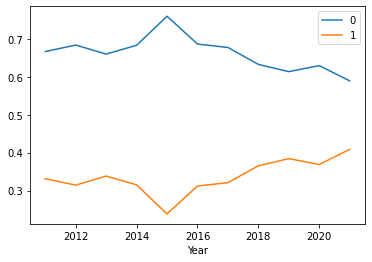

In [305]:
#what happen in 2015? 
cols = ['Year', '0', '1']
df3_topics[cols].groupby(['Year']) \
                  .mean() \
                  .plot();

## Dynamic Topic Modeling 

In [341]:
!pip install ipywidgets

In [308]:
from gensim.models import LdaSeqModel
from ipywidgets import interact

In [309]:
DTM =pd.read_csv('B&N_ALL_TEXTS.csv')

In [310]:
DTM

,Unnamed: 0,Text,Year
0,0,From Caldecott Honor artist Melissa Sweet come...,2011
1,1,From a New York Times bestselling and Hugo awa...,2011
2,2,"A masterpiece of postwar Polish literature, St...",2011
3,3,From the #1 New York Times-bestselling author ...,2011
4,4,Book one of the New York Times-bestselling All...,2011
...,...,...,...
2195,195,"“A haunted work, full of voices old and new. I...",2021
2196,196,ONE OF THE BEST BOOKS OF THE YEAR! - Publisher...,2021
2197,197,“Much more than a page-turner. It’s the first ...,2021
2198,198,Three kids who don’t belong. A room that shoul...,2021


In [311]:
time_slice = DTM.groupby('Year')['Text'].count().to_list()

In [313]:
for i in range(len(time_slice)):
    print("Documents in Time Slice {}:".format(i), time_slice[i])

Documents in Time Slice 0: 200
Documents in Time Slice 1: 200
Documents in Time Slice 2: 200
Documents in Time Slice 3: 200
Documents in Time Slice 4: 200
Documents in Time Slice 5: 200
Documents in Time Slice 6: 200
Documents in Time Slice 7: 200
Documents in Time Slice 8: 200
Documents in Time Slice 9: 200
Documents in Time Slice 10: 200


In [314]:
def tokenize_ob(text_series):
    '''
    Cleans, tokenizes + stems Pandas series of strings from
    the Old Bailey dataset.
    
    Returns pandas series of lists of tokens
    '''
    # Clean text with regex
    ob_regex = r"[^a-z\s]"
    clean = text_series.str.lower() \
                       .str.replace(ob_regex,
                                    "",
                                    regex=True)

    # Anonymous tokenizer + stemmer functions
    stopwords = nltk.corpus.stopwords.words('english')
    defined = ['book', 'books','read', 'story','stories','character','characters', 'help', 'author', 'authors',
               'write','much','many','little','less','im','time','times','new','york','one','best','bestselling', 
              'year', 'like','first','people','even','also','america','american','novel','readers','us','review','one',
              'two','three','four','five','years','makes','make','written','writing','way','reviews','never']
    stopwords = stopwords + defined
    
    tokenize = lambda text: [i for i in nltk.word_tokenize(text) if i not in stopwords]
    stemmer = lambda tokens: [SnowballStemmer('english').stem(token) for token in tokens]

    # Tokenize and stem clean text
    tokens = clean.apply(tokenize)
    stemmed_tokens = tokens.apply(stemmer)
    
    return stemmed_tokens

In [315]:
stemmed_tokens = tokenize_ob(DTM['Text'])

stemmed_tokens.head()

0    [caldecott, honor, artist, melissa, sweet, com...
1    [hugo, awardwin, come, modern, masterwork, sci...
2    [masterpiec, postwar, polish, literatur, stone...
3    [timesbestsel, lincoln, highway, gentleman, mo...
4    [timesbestsel, soul, trilogya, wonder, imagin,...
Name: Text, dtype: object

In [317]:
dictionary, bow_corpus = prepare_data(stemmed_tokens)

In [319]:
ldaseq = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=3)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [321]:
ldaseq.save('dtm.model')

In [322]:
def dtm_coherence(list_dtms, bow_corpus, dictionary, n_time_slices):
    '''
    Computes UMass Coherence for each time slice in a list of DTMs
    
    Input: List of Gensim LdaSeqModels, number of time slices modeled (int)
    Returns: Dict of lists of coherence scores for each DTM
    '''
    coherence = {}
    for i, ldaseq in enumerate(list_dtms):
        coherence[i] = []
        for t in range(n_time_slices):
            topics_dtm = ldaseq.dtm_coherence(t)
            cm_DTM = CoherenceModel(topics=topics_dtm,
                                    corpus=bow_corpus,
                                    dictionary=dictionary,
                                    coherence='u_mass')

            coherence[i].append(cm_DTM.get_coherence())
            
        return coherence

In [325]:
from gensim.models.coherencemodel import CoherenceModel

In [326]:
coherence = dtm_coherence([ldaseq],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# Can check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# As well as compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

Coherence at Time Slice 0: -0.7100635495911396
Coherence at Time Slice 1: -0.6995631847000848
Coherence at Time Slice 2: -0.7177209612866372
Coherence at Time Slice 3: -0.7312825819420753
Coherence at Time Slice 4: -0.763487002727917
Coherence at Time Slice 5: -0.7389201987822392
Coherence at Time Slice 6: -0.696039190409894
Coherence at Time Slice 7: -0.7505792555378488
Coherence at Time Slice 8: -0.7748208762058789
Coherence at Time Slice 9: -0.7794919476353471
Coherence at Time Slice 10: -0.7839079274971921
Average Coherence:  -0.7405342433014777


In [328]:
def print_dtm(dtm, n_topics, n_time_slices):
    '''
    Prints out top words in each topic across time slices for visual comparison
    
    Input: Gensim LdaSeqModel, n_topics (int), n_time_slices (int)
    '''
    for topic in range(n_topics):
        for time in range(n_time_slices): 
            print("##### Topic {}, Time Slice {} #####".format(topic, time))    
            print(dtm.dtm_coherence(time)[topic][:10])    
        print("\n")

In [329]:
print_dtm(ldaseq, n_topics=3, n_time_slices=11)

##### Topic 0, Time Slice 0 #####
['famili', 'love', 'children', 'star', 'school', 'illustr', 'life', 'find', 'page', 'work']
##### Topic 0, Time Slice 1 #####
['love', 'famili', 'star', 'children', 'school', 'life', 'illustr', 'find', 'humor', 'funni']
##### Topic 0, Time Slice 2 #####
['love', 'famili', 'star', 'life', 'school', 'children', 'illustr', 'find', 'humor', 'funni']
##### Topic 0, Time Slice 3 #####
['love', 'star', 'famili', 'life', 'school', 'illustr', 'find', 'children', 'humor', 'funni']
##### Topic 0, Time Slice 4 #####
['love', 'star', 'life', 'famili', 'school', 'find', 'children', 'illustr', 'humor', 'girl']
##### Topic 0, Time Slice 5 #####
['love', 'star', 'life', 'famili', 'school', 'girl', 'children', 'find', 'world', 'illustr']
##### Topic 0, Time Slice 6 #####
['love', 'star', 'life', 'famili', 'school', 'girl', 'find', 'world', 'children', 'illustr']
##### Topic 0, Time Slice 7 #####
['love', 'star', 'life', 'famili', 'school', 'librari', 'find', 'illustr', 

## dominant topics over time

In [330]:
topic_weights = pd.DataFrame([ldaseq.doc_topics(j) for j in range(len(bow_corpus))],
                             columns=['topic0', 'topic1', 'topic2'])
df = DTM.reset_index() \
            .merge(topic_weights,
                   left_index=True,
                   right_index=True)
df.head()

,index,Unnamed: 0,Text,Year,topic0,topic1,topic2
0,0,0,From Caldecott Honor artist Melissa Sweet come...,2011,0.927162,0.072820,0.000018
1,1,1,From a New York Times bestselling and Hugo awa...,2011,0.000022,0.033485,0.966493
2,2,2,"A masterpiece of postwar Polish literature, St...",2011,0.123182,0.876799,0.000019
3,3,3,From the #1 New York Times-bestselling author ...,2011,0.000015,0.507431,0.492554
4,4,4,Book one of the New York Times-bestselling All...,2011,0.000015,0.183809,0.816176


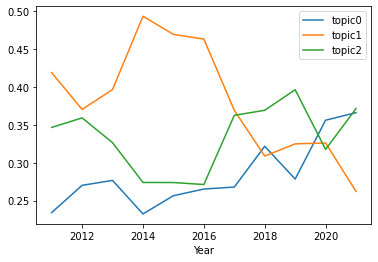

In [334]:
cols = ['Year', 'topic0', 'topic1', 'topic2']
df[cols].groupby(['Year'])\
                  .mean() \
                  .plot();